# COVID-19 Novel Coronavirus: EDA & Forecast Number of Cases

## Background

COVID-19 (previously known as 2019 Novel Coronavirus, or 2019-nCoV), is a new respiratory virus first identified in Wuhan, Hubei Province, China. A novel coronavirus (nCoV) is a new coronavirus that has not been previously identified. The 2019 novel coronavirus (2019-nCoV), is not that same as the coronaviruses that commonly circulate among humans and cause mild illness, like the common cold.

A diagnosis with coronavirus 229E, NL63, OC43, or HKU1 is not the same as a 2019-nCoV diagnosis. These are different viruses and patients with 2019-nCoV will be evaluated and cared for differently than patients with common coronavirus diagnosis. 

Public health officials and partners are working hard to identify the source of the 2019-nCoV. Coronaviruses are a large family of viruses, some causing illness in people and others that circulate among animals, including camels, cats and bats. Analysis of the genetic tree of this virus is ongoing to know the specific source of the virus. SARS, another coronavirus that emerged to infect people, came from civet cats, while MERS, another coronavirus that emerged to infect people, came from camels. More information about the source and spread of 2019-nCoV is available on the 2019-nCoV Situation Summary: Source and Spread of the Virus.

This virus probably originally emerged from an animal source but now seems to be spreading from person-to-person. It’s important to note that person-to-person spread can happen on a continuum. Some viruses are highly contagious (like measles), while other viruses are less so. At this time, it’s unclear how easily or sustainably this virus is spreading between people. Learn what is known about the spread of newly emerged coronaviruses.

**Reference:** https://www.cdc.gov/coronavirus/2019-ncov/faq.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from fbprophet import Prophet
import pycountry
import plotly.express as px
from collections import namedtuple

# Data Import, Preprocessing and EDA

In [2]:
df = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv',parse_dates=['Last Update'])
df.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)

df_confirmed = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv")
df_recovered = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv")
df_deaths = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv")

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)

In [3]:
df_confirmed.head()

,Province/State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,765,844,851,852,852,852,852,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,86,86,86,86,86,88,91,92,96,113


## Earliest Cases

In [4]:
df.head()

,SNo,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


## Latest Cases

In [5]:
df.tail()

,SNo,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
39342,39343,06/10/2020,Zacatecas,Mexico,2020-06-11 03:33:41,423.0,53.0,266.0
39343,39344,06/10/2020,Zakarpattia Oblast,Ukraine,2020-06-11 03:33:41,1448.0,33.0,628.0
39344,39345,06/10/2020,Zaporizhia Oblast,Ukraine,2020-06-11 03:33:41,502.0,15.0,296.0
39345,39346,06/10/2020,Zhejiang,Mainland China,2020-06-11 03:33:41,1268.0,1.0,1267.0
39346,39347,06/10/2020,Zhytomyr Oblast,Ukraine,2020-06-11 03:33:41,973.0,17.0,501.0


In [6]:
df2 = df.groupby(["Date", "Country", "Province/State"])[['SNo', 'Date', 'Province/State', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

## By Country View (World)

In [7]:
df2

,Date,Country,Province/State,SNo,Confirmed,Deaths,Recovered
0,01/22/2020,Hong Kong,Hong Kong,13,0.0,0.0,0.0
1,01/22/2020,Macau,Macau,21,1.0,0.0,0.0
2,01/22/2020,Mainland China,Anhui,1,1.0,0.0,0.0
3,01/22/2020,Mainland China,Beijing,2,14.0,0.0,0.0
4,01/22/2020,Mainland China,Chongqing,3,6.0,0.0,0.0
...,...,...,...,...,...,...,...
21661,06/10/2020,Ukraine,Vinnytsia Oblast,39318,1192.0,20.0,767.0
21662,06/10/2020,Ukraine,Volyn Oblast,39324,1214.0,37.0,310.0
21663,06/10/2020,Ukraine,Zakarpattia Oblast,39344,1448.0,33.0,628.0
21664,06/10/2020,Ukraine,Zaporizhia Oblast,39345,502.0,15.0,296.0


## By Country View (China)

In [8]:
df.query('Country=="Mainland China"').groupby("Last Update")[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22 17:00:00,547.0,17.0,28.0
1,2020-01-23 17:00:00,639.0,18.0,30.0
2,2020-01-24 17:00:00,916.0,26.0,36.0
3,2020-01-25 17:00:00,1399.0,42.0,39.0
4,2020-01-26 16:00:00,2062.0,56.0,49.0
...,...,...,...,...
857,2020-06-07 03:53:30,83036.0,4634.0,78331.0
858,2020-06-08 03:33:22,83040.0,4634.0,78340.0
859,2020-06-09 03:33:03,83043.0,4634.0,78350.0
860,2020-06-10 04:07:00,83046.0,4634.0,78356.0


## By Country (Sorted)

In [9]:
df.groupby("Country")[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Country,Confirmed,Deaths,Recovered
0,Azerbaijan,1.0,0.0,0.0
1,"('St. Martin',)",2.0,0.0,0.0
2,Afghanistan,445077.0,9163.0,46369.0
3,Albania,59018.0,2129.0,39125.0
4,Algeria,385692.0,33370.0,199571.0
...,...,...,...,...
218,Western Sahara,442.0,16.0,276.0
219,Yemen,8786.0,1863.0,352.0
220,Zambia,31793.0,329.0,18296.0
221,Zimbabwe,5157.0,259.0,871.0


# Visualizations

In [10]:
df.groupby('Date').sum()

,SNo,Confirmed,Deaths,Recovered
Date,,,,
01/22/2020,741,555.0,17.0,28.0
01/23/2020,2829,653.0,18.0,30.0
01/24/2020,4305,941.0,26.0,36.0
01/25/2020,6490,1438.0,42.0,39.0
01/26/2020,9071,2118.0,56.0,52.0
...,...,...,...,...
06/06/2020,24780294,6896917.0,399999.0,3085833.0
06/07/2020,25248150,7010582.0,402744.0,3140920.0
06/08/2020,25716006,7119002.0,406543.0,3293408.0


## Summary Plot of Worldwide Cases - Confirmed, Deaths & Recovered

In [11]:
confirmed = df.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df.groupby('Date').sum()['Deaths'].reset_index()
recovered = df.groupby('Date').sum()['Recovered'].reset_index()

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(x=confirmed['Date'],
                y=confirmed['Confirmed'],
                name='Confirmed',
                marker_color='blue'
                ))
fig.add_trace(go.Bar(x=deaths['Date'],
                y=deaths['Deaths'],
                name='Deaths',
                marker_color='Red'
                ))
fig.add_trace(go.Bar(x=recovered['Date'],
                y=recovered['Recovered'],
                name='Recovered',
                marker_color='Green'
                ))

fig.update_layout(
    title='Worldwide Corona Virus Cases - Confirmed, Deaths, Recovered (Bar Chart)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed['Date'], 
                         y=confirmed['Confirmed'],
                         mode='lines+markers',
                         name='Confirmed',
                         line=dict(color='blue', width=2)
                        ))
fig.add_trace(go.Scatter(x=deaths['Date'], 
                         y=deaths['Deaths'],
                         mode='lines+markers',
                         name='Deaths',
                         line=dict(color='Red', width=2)
                        ))
fig.add_trace(go.Scatter(x=recovered['Date'], 
                         y=recovered['Recovered'],
                         mode='lines+markers',
                         name='Recovered',
                         line=dict(color='Green', width=2)
                        ))
fig.update_layout(
    title='Worldwide Corona Virus Cases - Confirmed, Deaths, Recovered (Line Chart)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    )
)
fig.show()

In [14]:
df_confirmed = df_confirmed[["Province/State","Lat","Long","Country"]]
df_temp = df.copy()
df_temp['Country'].replace({'Mainland China': 'China'}, inplace=True)
df_latlong = pd.merge(df_temp, df_confirmed, on=["Country", "Province/State"])

In [15]:
fig = px.density_mapbox(df_latlong, 
                        lat="Lat", 
                        lon="Long", 
                        hover_name="Province/State", 
                        hover_data=["Confirmed","Deaths","Recovered"], 
                        animation_frame="Date",
                        color_continuous_scale="Portland",
                        radius=7, 
                        zoom=0,height=700)
fig.update_layout(title='Worldwide Corona Virus Cases Time Lapse - Confirmed, Deaths, Recovered',
                  font=dict(family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f")
                 )
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=0)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

## Analysis by Country

We use Plotly (https://plot.ly/python/bubble-maps/) for the visuals

### Latest Date in Data

In [16]:
confirmed = df2.groupby(['Date', 'Country']).sum()[['Confirmed']].reset_index()
deaths = df2.groupby(['Date', 'Country']).sum()[['Deaths']].reset_index()
recovered = df2.groupby(['Date', 'Country']).sum()[['Recovered']].reset_index()

In [17]:
latest_date = confirmed['Date'].max()
latest_date

'06/10/2020'

In [18]:
confirmed = confirmed[(confirmed['Date']==latest_date)][['Country', 'Confirmed']]
deaths = deaths[(deaths['Date']==latest_date)][['Country', 'Deaths']]
recovered = recovered[(recovered['Date']==latest_date)][['Country', 'Recovered']]

### Countries/Regions Affected

In [19]:
all_countries = confirmed['Country'].unique()
print("Number of countries/regions with cases: " + str(len(all_countries)))
print("Countries/Regions with cases: ")
for i in all_countries:
    print("    " + str(i))

Number of countries/regions with cases: 24
Countries/Regions with cases: 
    Australia
    Brazil
    Canada
    Chile
    Colombia
    Denmark
    France
    Germany
    Hong Kong
    India
    Italy
    Japan
    Macau
    Mainland China
    Mexico
    Netherlands
    Pakistan
    Peru
    Russia
    Spain
    Sweden
    UK
    US
    Ukraine


We need to do some processing to the country names for this bubble plot as some of the countries are not found in `pycountry.countries` although they are, just that its due to them being listed acronyms and with additional words, such as Mainland China instead of China.

In [20]:
print(list(country.name for country in pycountry.countries))

['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Åland Islands', 'Albania', 'Andorra', 'United Arab Emirates', 'Argentina', 'Armenia', 'American Samoa', 'Antarctica', 'French Southern Territories', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Bonaire, Sint Eustatius and Saba', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina', 'Saint Barthélemy', 'Belarus', 'Belize', 'Bermuda', 'Bolivia, Plurinational State of', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Bouvet Island', 'Botswana', 'Central African Republic', 'Canada', 'Cocos (Keeling) Islands', 'Switzerland', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon', 'Congo, The Democratic Republic of the', 'Congo', 'Cook Islands', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Curaçao', 'Christmas Island', 'Cayman Islands', 'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egy

In [21]:
print('UK' in list(country.name for country in pycountry.countries))
print('United Kingdom' in list(country.name for country in pycountry.countries))

False
True


In [22]:
confirmed2 = confirmed.copy()
deaths2 = deaths.copy()
recovered2 = recovered.copy()
bubble_plot_dfs = [confirmed2, deaths2, recovered2]
for df_ in bubble_plot_dfs:
    df_["Country"].replace({'Mainland China': 'China'}, inplace=True)
    df_["Country"].replace({'UK': 'United Kingdom'}, inplace=True)
    df_["Country"].replace({'US': 'United States'}, inplace=True)

In [23]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
    
confirmed2["iso_alpha"] = confirmed2["Country"].map(countries.get)
deaths2["iso_alpha"] = deaths2["Country"].map(countries.get)
recovered2["iso_alpha"] = recovered2["Country"].map(countries.get)

In [24]:
plot_data_confirmed = confirmed2[["iso_alpha","Confirmed", "Country"]]
plot_data_deaths = deaths2[["iso_alpha","Deaths"]]
plot_data_recovered = recovered2[["iso_alpha","Recovered"]]

In [25]:
fig = px.scatter_geo(plot_data_confirmed, locations="iso_alpha", color="Country",
                     hover_name="iso_alpha", size="Confirmed",
                     projection="natural earth", title = 'Worldwide Confirmed Cases')
fig.show()

In [26]:
fig = px.scatter_geo(plot_data_deaths, locations="iso_alpha", color="Deaths",
                     hover_name="iso_alpha", size="Deaths",
                     projection="natural earth", title="Worldwide Death Cases")
fig.show()

In [27]:
fig = px.scatter_geo(plot_data_recovered, locations="iso_alpha", color="Recovered",
                     hover_name="iso_alpha", size="Recovered",
                     projection="natural earth", title="Worldwide Recovered Cases")
fig.show()

## Transforming Data for Forecasting

In [28]:
confirmed = df.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df.groupby('Date').sum()['Deaths'].reset_index()
recovered = df.groupby('Date').sum()['Recovered'].reset_index()

In [29]:
confirmed.columns = ['ds','y']
#confirmed['ds'] = confirmed['ds'].dt.date
confirmed['ds'] = pd.to_datetime(confirmed['ds'])

In [30]:
confirmed.head()

,ds,y
0,2020-01-22,555.0
1,2020-01-23,653.0
2,2020-01-24,941.0
3,2020-01-25,1438.0
4,2020-01-26,2118.0


# Forecasting Total Number of Cases Worldwide

## Prophet

We use Prophet, a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. It is also an open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

## Why Prophet?

Prophet is easy to customize and use, and to produce accurate forecasts which can be explained intuitively with supporting evidence such as forecast seasonality components. It allows the analyst to explain in an intuitive and convinving manner to higher management as to why the forecasts are as such, and the plausible underlying factors that contribute to its result. Furthermore, it is also open-source! :)

## References 
- https://facebook.github.io/prophet/
- https://facebook.github.io/prophet/docs/
- https://github.com/facebook/prophet

## Forecasting Confirmed Cases Worldwide with Prophet (Baseline)

We perform a week's ahead forecast with Prophet, with 95% prediction intervals. Here, no tweaking of seasonality-related parameters and additional regressors are performed.

In [31]:
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=7)
future_confirmed = future.copy() # for non-baseline predictions later on
future.tail()

,ds
143,2020-06-13
144,2020-06-14
145,2020-06-15
146,2020-06-16
147,2020-06-17


In [32]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
143,2020-06-13,7.578970e+06,7.520471e+06,7.636156e+06
144,2020-06-14,7.682422e+06,7.623995e+06,7.745819e+06
145,2020-06-15,7.782925e+06,7.717268e+06,7.849877e+06
146,2020-06-16,7.887346e+06,7.817621e+06,7.953485e+06
147,2020-06-17,7.993367e+06,7.917455e+06,8.073574e+06


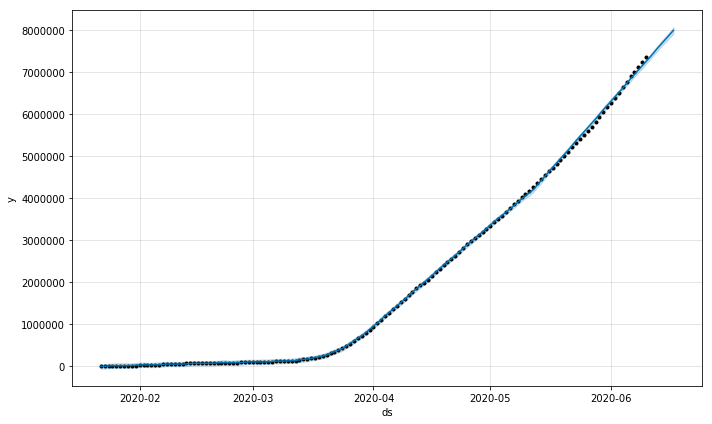

In [33]:
confirmed_forecast_plot = m.plot(forecast)

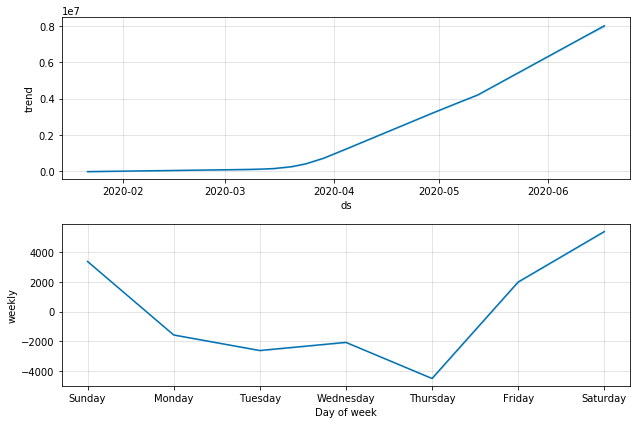

In [34]:
forecast_components = m.plot_components(forecast)

## Forecasting Deaths Worldwide with Prophet (Baseline)

We perform a week's ahead forecast with Prophet, with 95% prediction intervals. Here, no tweaking of seasonality-related parameters and additional regressors are performed.

In [35]:
deaths.columns = ['ds','y']
deaths['ds'] = pd.to_datetime(deaths['ds'])

In [36]:
m = Prophet(interval_width=0.95)
m.fit(deaths)
future = m.make_future_dataframe(periods=7)
future_deaths = future.copy() # for non-baseline predictions later on
future.tail()

,ds
143,2020-06-13
144,2020-06-14
145,2020-06-15
146,2020-06-16
147,2020-06-17


In [37]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
143,2020-06-13,428818.222675,426729.744585,431106.492410
144,2020-06-14,432292.502398,429537.399420,435150.972568
145,2020-06-15,435762.110160,432171.449218,439573.492427
146,2020-06-16,440156.423145,435553.558264,445389.991865
147,2020-06-17,444967.163381,439291.395862,451501.355514


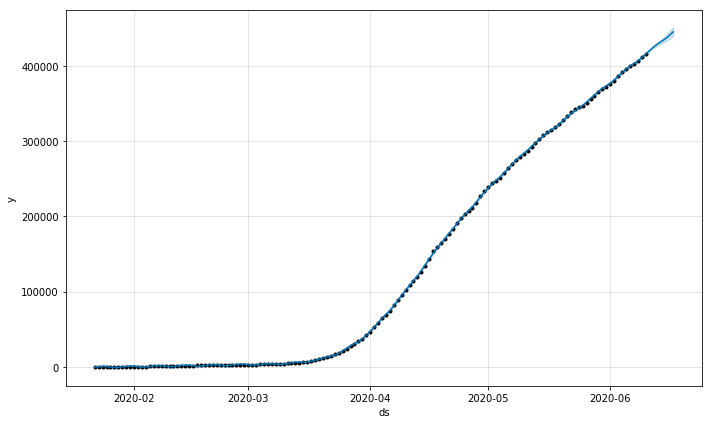

In [38]:
deaths_forecast_plot = m.plot(forecast)

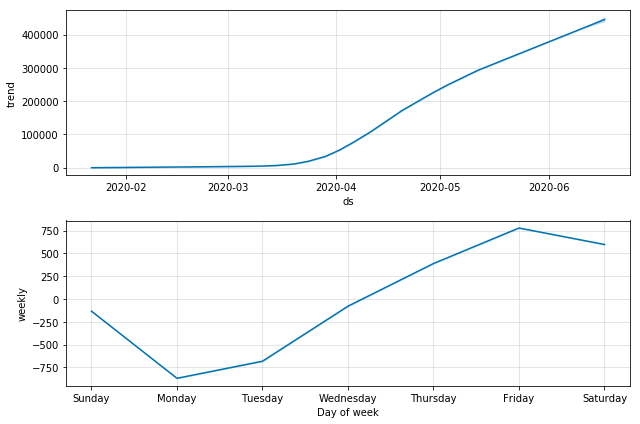

In [39]:
forecast_components = m.plot_components(forecast)

## Forecasting Recovered Cases Worldwide with Prophet (Baseline)

We perform a week's ahead forecast with Prophet, with 95% prediction intervals. Here, no tweaking of seasonality-related parameters and additional regressors are performed.

In [40]:
recovered.columns = ['ds','y']
recovered['ds'] = pd.to_datetime(recovered['ds'])

In [41]:
m = Prophet(interval_width=0.95)
m.fit(recovered)
future = m.make_future_dataframe(periods=7)
future_recovered = future.copy() # for non-baseline predictions later on
future.tail()

,ds
143,2020-06-13
144,2020-06-14
145,2020-06-15
146,2020-06-16
147,2020-06-17


In [42]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
143,2020-06-13,3.507794e+06,3.454379e+06,3.557137e+06
144,2020-06-14,3.570938e+06,3.512544e+06,3.626594e+06
145,2020-06-15,3.638672e+06,3.582822e+06,3.693451e+06
146,2020-06-16,3.701761e+06,3.635566e+06,3.761146e+06
147,2020-06-17,3.768568e+06,3.702332e+06,3.833140e+06


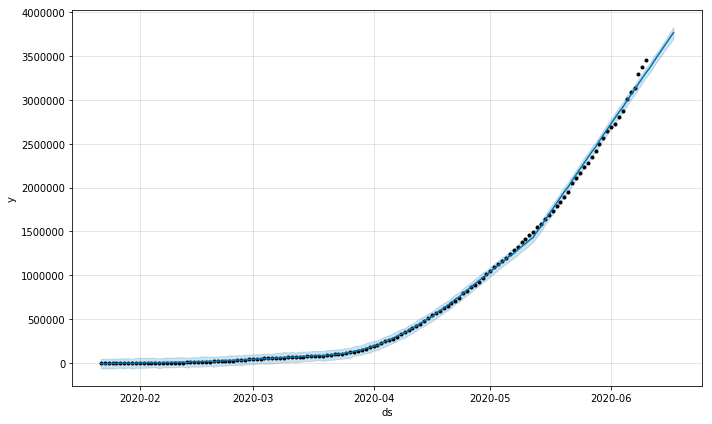

In [43]:
recovered_forecast_plot = m.plot(forecast)

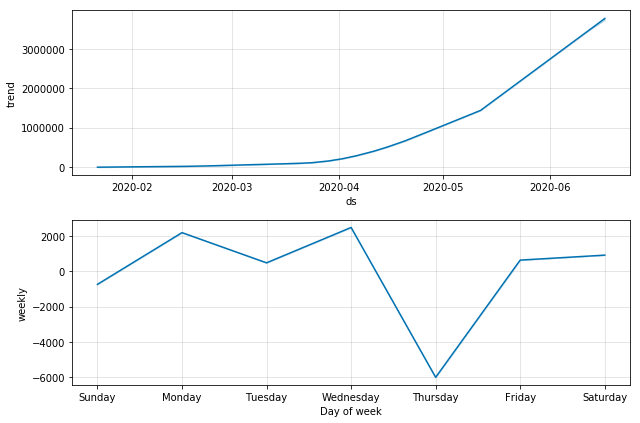

In [44]:
forecast_components = m.plot_components(forecast)

Seems pretty decent for a baseline Prophet model in the case of the number of recovered! :)

From the forecast component plots, it is clear that there exists an upward trend in the number of cases worldwide. In the weekly trends plot, interestingly, it is the **highest at the weekends**!

# Forecasting Confirmed, Death & Recovered Cases Worldwide with Prophet (by Country/Region & Province/State)

## With Baseline Prophet Model (Using Default Parameters), Prophet Model with Custom Seasonalities & Fourier Orders

### Data Preparation

As we are now forecasting at country and state/province level, for small values, it is possible for forecasts to become negative. To counter this, we round negative values to zero. To perform forecast evaluations using mean absolute error (MAE), we require to partition the dataset into train & validation sets. Here, the test set will contain the dates for which the Prophet model is trained on and where forecasts were made.

In [45]:
days_to_forecast = 7 # changable
first_forecasted_date = sorted(list(set(df2['Date'].values)))[-days_to_forecast]

print('The first date to perform forecasts for is: ' + str(first_forecasted_date))

The first date to perform forecasts for is: 06/04/2020


In [46]:
confirmed_df = df2[['SNo', 'Date','Province/State', 'Country', 'Confirmed']]
confirmed_df

,SNo,Date,Province/State,Country,Confirmed
0,13,01/22/2020,Hong Kong,Hong Kong,0.0
1,21,01/22/2020,Macau,Macau,1.0
2,1,01/22/2020,Anhui,Mainland China,1.0
3,2,01/22/2020,Beijing,Mainland China,14.0
4,3,01/22/2020,Chongqing,Mainland China,6.0
...,...,...,...,...,...
21661,39318,06/10/2020,Vinnytsia Oblast,Ukraine,1192.0
21662,39324,06/10/2020,Volyn Oblast,Ukraine,1214.0
21663,39344,06/10/2020,Zakarpattia Oblast,Ukraine,1448.0
21664,39345,06/10/2020,Zaporizhia Oblast,Ukraine,502.0


In [47]:
deaths_df = df2[['SNo', 'Date','Province/State', 'Country', 'Deaths']]
deaths_df

,SNo,Date,Province/State,Country,Deaths
0,13,01/22/2020,Hong Kong,Hong Kong,0.0
1,21,01/22/2020,Macau,Macau,0.0
2,1,01/22/2020,Anhui,Mainland China,0.0
3,2,01/22/2020,Beijing,Mainland China,0.0
4,3,01/22/2020,Chongqing,Mainland China,0.0
...,...,...,...,...,...
21661,39318,06/10/2020,Vinnytsia Oblast,Ukraine,20.0
21662,39324,06/10/2020,Volyn Oblast,Ukraine,37.0
21663,39344,06/10/2020,Zakarpattia Oblast,Ukraine,33.0
21664,39345,06/10/2020,Zaporizhia Oblast,Ukraine,15.0


In [48]:
recovered_df = df2[['SNo', 'Date','Province/State', 'Country', 'Recovered']]
recovered_df

,SNo,Date,Province/State,Country,Recovered
0,13,01/22/2020,Hong Kong,Hong Kong,0.0
1,21,01/22/2020,Macau,Macau,0.0
2,1,01/22/2020,Anhui,Mainland China,0.0
3,2,01/22/2020,Beijing,Mainland China,0.0
4,3,01/22/2020,Chongqing,Mainland China,0.0
...,...,...,...,...,...
21661,39318,06/10/2020,Vinnytsia Oblast,Ukraine,767.0
21662,39324,06/10/2020,Volyn Oblast,Ukraine,310.0
21663,39344,06/10/2020,Zakarpattia Oblast,Ukraine,628.0
21664,39345,06/10/2020,Zaporizhia Oblast,Ukraine,296.0


### Forecasting Confirmed Cases, Deaths & Recovered Cases and Computing Mean Absolute Error (MAE)

Next, we perform predictions for each country and state. Note that we compute MAE with the raw predictions before rounding.

In [49]:
def make_forecasts(all_countries, confirmed_df, deaths_df, recovered_df, days_to_forecast, first_forecasted_date, mode):
    forecast_dfs = []
    absolute_errors = [] # collate absolute errors so that we can find MAE later on
    counter = 0 # arbitrary counter to output snippet of result_val_df only once, when it is 1
    for country in all_countries:
        try:
            assert(country in confirmed_df['Country'].values)
            print('Country ' + str(country) + ' is listed! ')
            country_confirmed_df = confirmed_df[(confirmed_df['Country'] == country)]
            country_deaths_df = deaths_df[(deaths_df['Country'] == country)]
            country_recovered_df = recovered_df[(recovered_df['Country'] == country)]
            country_dfs = [('Confirmed', country_confirmed_df), 
                           ('Deaths', country_deaths_df), 
                           ('Recovered', country_recovered_df)]
            states_in_country = country_confirmed_df['Province/State'].unique()
            for state in states_in_country:
                try:
                    state_dfs = [] # to store forecasts for Confirmed, Deaths and Recovered

                    assert(state in country_confirmed_df['Province/State'].values)

                    # make forecasts for each case type (Confirmed, Deaths, Recovered)
                    for country_df_tup in country_dfs:
                        case_type = country_df_tup[0]
                        country_df = country_df_tup[1]
                        state_df = country_df[(country_df['Province/State'] == state)]

                        # data preparation for forecast with Prophet at state level
                        state_df = state_df[['Date', case_type]]
                        state_df.columns = ['ds','y']
                        state_df['ds'] = pd.to_datetime(state_df['ds'])

                        state_df_val = state_df[(state_df['ds'] >= pd.to_datetime(first_forecasted_date))] # validation set
                        state_df = state_df[(state_df['ds'] < pd.to_datetime(first_forecasted_date))] # train set

                        if mode == 'default':
                            m = Prophet()
                        elif mode == 'custom':
                            m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
                            m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
                            m.add_seasonality(name='weekly', period=7, fourier_order=21)
                            m.add_seasonality(name='daily', period=1, fourier_order=3)
                        m.fit(state_df)
                        future = m.make_future_dataframe(periods=days_to_forecast)
                        forecast = m.predict(future)

                        # evaluate forecasts with validation set and save absolute errors to absolute_errors
                        forecast_df = forecast[['ds', 'yhat']]
                        result_df = forecast_df[(forecast_df['ds'] >= pd.to_datetime(first_forecasted_date))]
                        result_val_df = result_df.merge(state_df_val, on=['ds'])
                        result_val_df['abs_diff'] = (result_val_df['y'] - result_val_df['yhat']).abs()
                        absolute_errors += list(result_val_df['abs_diff'].values)

                        # the following allows the user to check the output at particular checkpoints. Feel free to change!
                        if counter == 1:
                            print('Printing snippet of result_val_df: \n')
                            print(result_val_df)
                            print(absolute_errors)
                        counter += 1

                        # save results to dataframe
                        forecast_df['Province/State'] = state
                        forecast_df['Country/Region'] = country
                        forecast_df.rename(columns={'yhat':case_type}, inplace=True)
                        state_dfs += [forecast_df.tail(days_to_forecast)]

                    merged_df = state_dfs[0].merge(state_dfs[1],on=['ds', 'Province/State', 'Country/Region']).merge(state_dfs[2],on=['ds', 'Province/State', 'Country/Region'])
                    forecast_dfs += [merged_df]
                except:
                    continue
        except:
            print('Country ' + str(country) + ' is not listed! ')
            continue
    results_tup = namedtuple('results_tup', ['forecast_dfs', 'absolute_errors'])
    return results_tup(forecast_dfs, absolute_errors)

In [50]:
forecast_results = make_forecasts(all_countries, confirmed_df, deaths_df, recovered_df, days_to_forecast, first_forecasted_date, 'default')
absolute_errors = forecast_results.absolute_errors

Country Australia is listed! 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

Printing snippet of result_val_df: 

          ds       yhat     y  abs_diff
0 2020-06-04  49.893729  48.0  1.893729
1 2020-06-05  50.105437  48.0  2.105437
2 2020-06-06  50.106763  48.0  2.106763
3 2020-06-07  50.425293  48.0  2.425293
4 2020-06-08  50.494046  48.0  2.494046
5 2020-06-09  51.028257  48.0  3.028257
6 2020-06-10  51.078835  48.0  3.078835
[729.3468181222438, 753.9289537854374, 781.0690695931899, 807.5881333534803, 859.4656924965939, 870.8280905653378, 897.206271059797, 1.8937290557857196, 2.1054368664100096, 2.106763317188232, 2.4252930710314473, 2.494045702087462, 3.0282570725819937, 3.0788351054635186]
Country Brazil is listed! 
Country Canada is listed! 
Country Chile is listed! 
Country Colombia is listed! 
Country Denmark is listed! 
Country France is listed! 
Country Germany is listed! 
Country Hong Kong is listed! 
Country India is listed! 
Country Italy is listed! 
Country Japan is listed! 
Country Macau is listed! 
Country Mainland China is listed! 
Country Mex

In [51]:
forecast_results.forecast_dfs[0].tail(days_to_forecast) # example of a forecast

,ds,Confirmed,Province/State,Country/Region,Deaths,Recovered
0,2020-06-04,3839.346818,New South Wales,Australia,49.893729,3265.603134
1,2020-06-05,3863.928954,New South Wales,Australia,50.105437,3366.054189
2,2020-06-06,3890.069070,New South Wales,Australia,50.106763,3433.400906
3,2020-06-07,3919.588133,New South Wales,Australia,50.425293,3457.268744
4,2020-06-08,3973.465692,New South Wales,Australia,50.494046,3492.126163
5,2020-06-09,3987.828091,New South Wales,Australia,51.028257,3522.035615
6,2020-06-10,4014.206271,New South Wales,Australia,51.078835,3549.446295


### Some Final Touch-ups..

In [52]:
forecasts_final = pd.concat(forecast_results.forecast_dfs, axis=0)
forecasts_final.sort_values(by='ds')
forecasts_final = forecasts_final[['ds', 'Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
forecasts_final.rename(columns={'ds':'ObservationDate'}, inplace=True)
for case_type in ['Confirmed', 'Deaths', 'Recovered']:
    forecasts_final[case_type] = forecasts_final[case_type].round() # round forecasts to integer as humans cannot be floats
    forecasts_final[forecasts_final[case_type] < 0] = 0 # replace negative forecasts to zero

forecasts_final

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-06-04 00:00:00,New South Wales,Australia,3839.0,50.0,3266.0
1,2020-06-05 00:00:00,New South Wales,Australia,3864.0,50.0,3366.0
2,2020-06-06 00:00:00,New South Wales,Australia,3890.0,50.0,3433.0
3,2020-06-07 00:00:00,New South Wales,Australia,3920.0,50.0,3457.0
4,2020-06-08 00:00:00,New South Wales,Australia,3973.0,50.0,3492.0
...,...,...,...,...,...,...
2,2020-06-06 00:00:00,Zhytomyr Oblast,Ukraine,792.0,14.0,559.0
3,2020-06-07 00:00:00,Zhytomyr Oblast,Ukraine,796.0,14.0,588.0
4,2020-06-08 00:00:00,Zhytomyr Oblast,Ukraine,800.0,14.0,617.0
5,2020-06-09 00:00:00,Zhytomyr Oblast,Ukraine,804.0,14.0,646.0


In [53]:
forecasts_final.to_csv("forecasts_default_prophet.csv", index=False) # save forecasts to CSV

## Prophet with Daily & Weekly Seasonality (with custom Fourier orders)

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the add_seasonality method (Python) or function (R).

The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. An optional input to add_seasonality is the prior scale for that seasonal component - this is discussed below.

**Source:** https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#fourier-order-for-seasonalities

In [54]:
forecast_results_custom = make_forecasts(all_countries, confirmed_df, deaths_df, recovered_df, days_to_forecast, first_forecasted_date, 'custom')
absolute_errors_custom = forecast_results_custom.absolute_errors
forecast_dfs_custom = forecast_results_custom.forecast_dfs

Country Australia is listed! 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

Printing snippet of result_val_df: 

          ds       yhat     y  abs_diff
0 2020-06-04  50.682941  48.0  2.682941
1 2020-06-05  51.445227  48.0  3.445227
2 2020-06-06  51.719144  48.0  3.719144
3 2020-06-07  52.561980  48.0  4.561980
4 2020-06-08  52.786540  48.0  4.786540
5 2020-06-09  52.748871  48.0  4.748871
6 2020-06-10  52.570948  48.0  4.570948
[909.4965320918454, 972.0698455614297, 965.8950033878668, 972.5168373821957, 1006.5485155178367, 989.5970759376405, 995.3228294805795, 2.6829405974052065, 3.4452274047267295, 3.71914368148542, 4.561980315430638, 4.78653966101848, 4.7488708684223155, 4.570947575967125]
Country Brazil is listed! 
Country Canada is listed! 
Country Chile is listed! 
Country Colombia is listed! 
Country Denmark is listed! 
Country France is listed! 
Country Germany is listed! 
Country Hong Kong is listed! 
Country India is listed! 
Country Italy is listed! 
Country Japan is listed! 
Country Macau is listed! 
Country Mainland China is listed! 
Country Mexic

In [55]:
forecasts_final_custom = pd.concat(forecast_dfs_custom, axis=0)
forecasts_final_custom.sort_values(by='ds')
forecasts_final_custom = forecasts_final_custom[['ds', 'Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
forecasts_final_custom.rename(columns={'ds':'ObservationDate'}, inplace=True)
for case_type in ['Confirmed', 'Deaths', 'Recovered']:
    forecasts_final_custom[case_type] = forecasts_final_custom[case_type].round() # round forecasts to integer as humans cannot be floats
    forecasts_final_custom[forecasts_final_custom[case_type] < 0] = 0 # replace negative forecasts to zero

forecasts_final_custom

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-06-04 00:00:00,New South Wales,Australia,4019.0,51.0,3321.0
1,2020-06-05 00:00:00,New South Wales,Australia,4082.0,51.0,3465.0
2,2020-06-06 00:00:00,New South Wales,Australia,4075.0,52.0,3494.0
3,2020-06-07 00:00:00,New South Wales,Australia,4085.0,53.0,3493.0
4,2020-06-08 00:00:00,New South Wales,Australia,4121.0,53.0,3480.0
...,...,...,...,...,...,...
2,0,0,0,0.0,0.0,0.0
3,0,0,0,0.0,0.0,0.0
4,0,0,0,0.0,0.0,0.0
5,0,0,0,0.0,0.0,0.0


In [56]:
forecasts_final_custom.to_csv("forecasts_custom_prophet.csv", index=False) # save forecasts to CSV

# Evaluation of Forecasts (Mean Absolute Error)

In [57]:
N = len(absolute_errors)
mean_absolute_error = sum(absolute_errors)/N
print('The mean absolute error for ' + str(days_to_forecast) + ' days of forecasts with the default Prophet model is: ' + str(round(mean_absolute_error, 2))) # round to 2 decimal places

The mean absolute error for 7 days of forecasts with the default Prophet model is: 361.31


In [58]:
mean_absolute_error_custom = sum(absolute_errors_custom)/N
print('The mean absolute error for ' + str(days_to_forecast) + ' days of forecasts with the custom Prophet model is: ' + str(round(mean_absolute_error_custom, 2))) # round to 2 decimal places

The mean absolute error for 7 days of forecasts with the custom Prophet model is: 30364.02


## This kernel will be periodically updated, with refresh in visualizations and forecasts (with new models)